## Install needed libaries

In [1]:
!pip install transformers torch scikit-learn pandas matplotlib


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Import data


In [3]:
# Load the dataset
file_path = '/content/train-00000-of-00001 (1).parquet'
df = pd.read_parquet(file_path)

# Inspect the dataset
print("Dataset Shape:", df.shape)
print(df.head())

# Extract texts and labels
texts = df['text'].tolist()
labels = df['label'].tolist()


Dataset Shape: (416809, 2)
                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2


# Exploratory Analysis

check if there is any missing value.

In [4]:
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
text     0
label    0
dtype: int64


check the distribution of the labels.

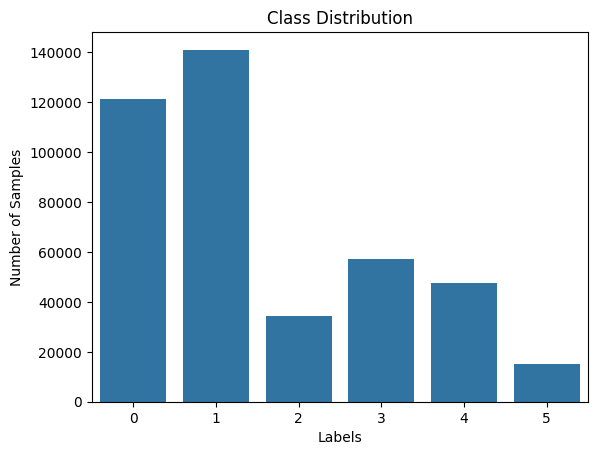

Class Distribution:
 label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


In [5]:

import seaborn as sns

# Count the number of samples for each label
label_counts = df['label'].value_counts()

# Plot the class distribution
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

# Print the actual counts
print("Class Distribution:\n", label_counts)


descriptive analysis.

Text length stats:
count    416809.000000
mean         97.028397
std          56.198232
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text, dtype: float64


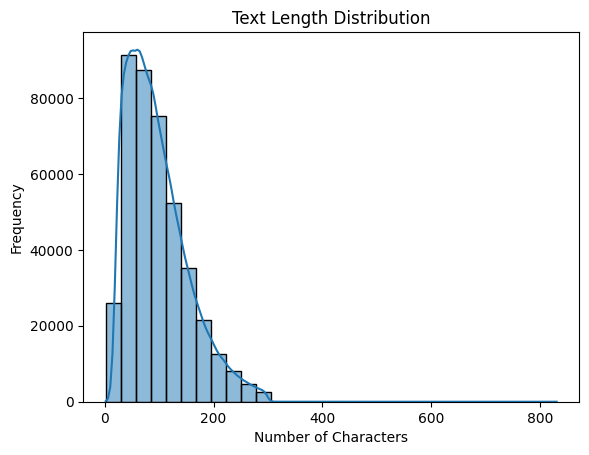

In [6]:
# Calculate text lengths
text_lengths = df['text'].apply(len)

# Basic statistics
print("Text length stats:")
print(text_lengths.describe())

# Plot histogram
sns.histplot(text_lengths, bins=30, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


# Data preparation

In [7]:
# Use x% of the data for experimentation
df_sample = df.sample(frac=0.1, random_state=42)
texts = df_sample['text'].tolist()
labels = df_sample['label'].tolist()

print(f"Using {len(texts)} samples for feature extraction.")



Using 41681 samples for feature extraction.


In [8]:
# Train-test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
# Validation-test split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_texts)}, Validation: {len(val_texts)}, Test: {len(test_texts)}")


Train: 33344, Validation: 4168, Test: 4169


In [9]:
# Load ALBERT tokenizer and model
model_name = "huawei-noah/TinyBERT_General_4L_312D" ##pre trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
albert_model = AutoModel.from_pretrained(model_name)
albert_model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-3): 4 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


# Extract latent features from pre-trained model

It is hard to train the pre-trained model since it will cost a lot of time and computational resources. So here we are using the pre-trained model to extract the latent feature, and then build and train our own neural network.

In [10]:
from torch.cuda.amp import autocast

def extract_features(texts, batch_size=8, max_length=64, device="cuda"):
    albert_model.to(device)
    features = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            encoded = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=max_length,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            with autocast():  # Use mixed precision
                outputs = albert_model(input_ids, attention_mask=attention_mask)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token
                features.append(cls_embeddings)
    return torch.cat(features, dim=0)


In [11]:
def save_features_to_disk(texts, labels, file_name, batch_size=8, max_length=64, device="cpu"):
    features = extract_features(texts, batch_size=batch_size, max_length=max_length, device="cpu")
    torch.save((features, torch.tensor(labels)), file_name)

# Save features for train, validation, and test sets
save_features_to_disk(train_texts, train_labels, "train_features.pt")
save_features_to_disk(val_texts, val_labels, "val_features.pt")
save_features_to_disk(test_texts, test_labels, "test_features.pt")

# Load features when needed
train_features, train_labels = torch.load("train_features.pt")
val_features, val_labels = torch.load("val_features.pt")
test_features, test_labels = torch.load("test_features.pt")


<ipython-input-10-ba9e11a34497>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
<ipython-input-11-f4e4d554c76d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

In [12]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Baseline modle using one fully connected layer

In [13]:
## define the model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Single fully connected layer

    def forward(self, x):
        return self.fc(x)  # No activation for baseline


In [14]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the simplest classifier
input_dim = train_features.shape[1]  # Feature size from DistilBERT
num_classes = len(set(labels))  # Number of unique labels
simplest_classifier = SimpleClassifier(input_dim, num_classes).to(device)


In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simplest_classifier.parameters(), lr=5e-5)

# Training loop with early stopping
epochs = 200
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to track the number of epochs without improvement

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    simplest_classifier.train()
    total_train_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = simplest_classifier(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Validation phase
    simplest_classifier.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = simplest_classifier(batch_features)
            loss = criterion(outputs, batch_labels)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    val_losses.append(total_val_loss / len(val_loader))
    val_accuracy = accuracy_score(all_labels, all_preds)

    # Print results every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:  # Always show the result at epoch 1
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early Stopping: Check if validation loss improved
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]  # Update best validation loss
        patience_counter = 0  # Reset patience counter
        torch.save(simplest_classifier.state_dict(), 'best_model.pt')  # Save the best model
    else:
        patience_counter += 1  # Increment patience counter
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    # Stop training if patience counter exceeds the threshold
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best Val Loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
simplest_classifier.load_state_dict(torch.load('best_model.pt'))
print("Best model loaded for evaluation.")


Epoch 1/200, Train Loss: 1.4638, Val Loss: 1.3402, Val Accuracy: 0.5238
Epoch 10/200, Train Loss: 1.1663, Val Loss: 1.1635, Val Accuracy: 0.5653
Epoch 20/200, Train Loss: 1.1264, Val Loss: 1.1252, Val Accuracy: 0.5770
Epoch 30/200, Train Loss: 1.1047, Val Loss: 1.1035, Val Accuracy: 0.5859
Epoch 40/200, Train Loss: 1.0908, Val Loss: 1.0892, Val Accuracy: 0.5905
Epoch 50/200, Train Loss: 1.0805, Val Loss: 1.0787, Val Accuracy: 0.5967
Epoch 60/200, Train Loss: 1.0725, Val Loss: 1.0713, Val Accuracy: 0.5984
Epoch 70/200, Train Loss: 1.0660, Val Loss: 1.0644, Val Accuracy: 0.6005
No improvement in validation loss for 1 epoch(s).
Epoch 80/200, Train Loss: 1.0606, Val Loss: 1.0590, Val Accuracy: 0.6010
No improvement in validation loss for 1 epoch(s).
Epoch 90/200, Train Loss: 1.0561, Val Loss: 1.0540, Val Accuracy: 0.6048
No improvement in validation loss for 1 epoch(s).
Epoch 100/200, Train Loss: 1.0519, Val Loss: 1.0505, Val Accuracy: 0.6068
No improvement in validation loss for 1 epoch(s

<ipython-input-15-1fb674fcb5a7>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simplest_classifier.load_state_dict(torch.load('best_model.pt'))


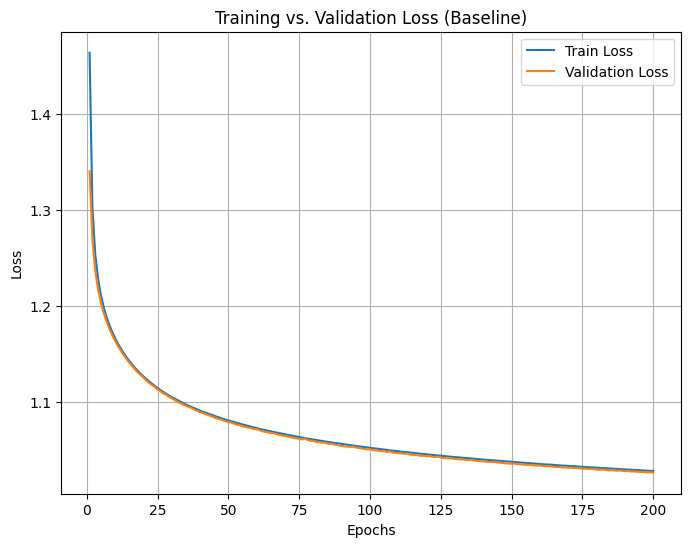

In [16]:
# Match the length of the shorter list
min_epochs = min(len(train_losses), len(val_losses))

plt.figure(figsize=(8, 6))
plt.plot(range(1, min_epochs + 1), train_losses[:min_epochs], label="Train Loss")
plt.plot(range(1, min_epochs + 1), val_losses[:min_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (Baseline)")
plt.legend()
plt.grid()
plt.show()


<ipython-input-17-c461c3f07c3f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simplest_classifier.load_state_dict(torch.load('best_model.pt'))


Best model loaded for evaluation.
Test Accuracy: 0.6181

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.77      0.68      1227
     Class 1       0.67      0.81      0.73      1406
     Class 2       0.39      0.11      0.17       341
     Class 3       0.61      0.40      0.48       569
     Class 4       0.52      0.43      0.47       472
     Class 5       0.53      0.21      0.31       154

    accuracy                           0.62      4169
   macro avg       0.55      0.46      0.47      4169
weighted avg       0.60      0.62      0.59      4169



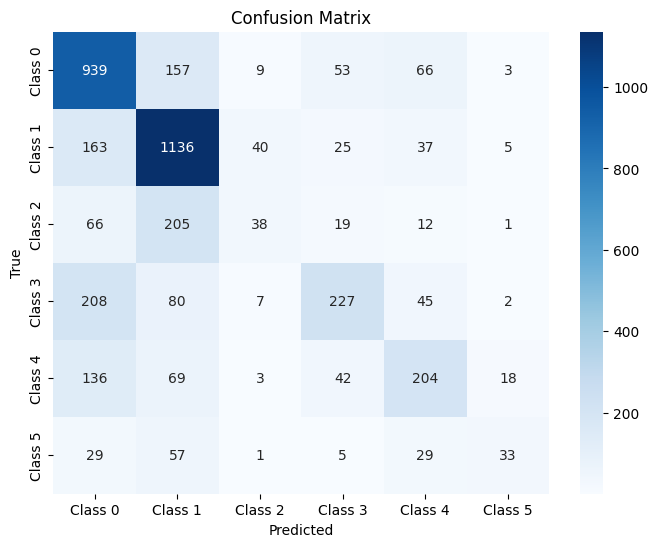

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model for evaluation
simplest_classifier.load_state_dict(torch.load('best_model.pt'))
simplest_classifier.eval()  # Set model to evaluation mode
print("Best model loaded for evaluation.")

# Evaluate on test data
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = simplest_classifier(batch_features)
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']  # Modify based on your dataset
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# MLP （Fine-tuned model）

Then we build multi-layer perceptron model, fine-tuned the hyperprematers while training.

In [18]:
# define the model
import torch.nn as nn

class ResidualMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

        # Projection layers to align dimensions for residual connections
        self.proj_fc2 = nn.Linear(512, 256)
        self.proj_fc3 = nn.Linear(256, 128)
        self.proj_fc4 = nn.Linear(128, 64)

    def forward(self, x):
        # First layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second layer with residual connection
        residual2 = self.proj_fc2(x)  # Align dimensions
        x = self.fc2(x)
        x += residual2  # Add residual connection
        x = self.relu(x)
        x = self.dropout(x)

        # Third layer with residual connection
        residual3 = self.proj_fc3(x)  # Align dimensions
        x = self.fc3(x)
        x += residual3  # Add residual connection
        x = self.relu(x)
        x = self.dropout(x)

        # Fourth layer with residual connection
        residual4 = self.proj_fc4(x)  # Align dimensions
        x = self.fc4(x)
        x += residual4  # Add residual connection
        x = self.relu(x)
        x = self.dropout(x)

        # Fifth layer (output)
        x = self.fc5(x)
        return x


In [19]:
# Define loss function and optimizer
model = ResidualMLP(input_dim, num_classes).to(device)  # Ensure this is defined
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)

# Add a learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


In [20]:

# Training loop with early stopping
epochs = 200
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to track the number of epochs without improvement

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    val_losses.append(total_val_loss / len(val_loader))
    val_accuracy = accuracy_score(all_labels, all_preds)

    # Scheduler step
    scheduler.step(val_losses[-1])

    # Print results every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:  # Always show the result at epoch 1
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.1e}")

    # Early Stopping: Check if validation loss improved
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]  # Update best validation loss
        patience_counter = 0  # Reset patience counter
        torch.save(model.state_dict(), 'best_model1.pt')  # Save the best model
        print(f"Best model updated at epoch {epoch+1}.")
    else:
        patience_counter += 1  # Increment patience counter
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    # Stop training if patience counter exceeds the threshold
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best Val Loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model1.pt'))
print("Best model loaded for evaluation.")


Epoch 1/200, Train Loss: 1.3627, Val Loss: 1.2294, Val Accuracy: 0.5362, LR: 5.0e-05
Best model updated at epoch 1.
Best model updated at epoch 2.
Best model updated at epoch 3.
Best model updated at epoch 4.
Best model updated at epoch 5.
Best model updated at epoch 6.
Best model updated at epoch 7.
Best model updated at epoch 8.
Best model updated at epoch 9.
Epoch 10/200, Train Loss: 1.0533, Val Loss: 1.0047, Val Accuracy: 0.6233, LR: 5.0e-05
Best model updated at epoch 10.
Best model updated at epoch 11.
Best model updated at epoch 12.
Best model updated at epoch 13.
Best model updated at epoch 14.
Best model updated at epoch 15.
Best model updated at epoch 16.
Best model updated at epoch 17.
No improvement in validation loss for 1 epoch(s).
Best model updated at epoch 19.
Epoch 20/200, Train Loss: 0.9639, Val Loss: 0.9600, Val Accuracy: 0.6404, LR: 5.0e-05
No improvement in validation loss for 1 epoch(s).
Best model updated at epoch 21.
No improvement in validation loss for 1 epoc

<ipython-input-20-e25a9bae2428>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model1.pt'))


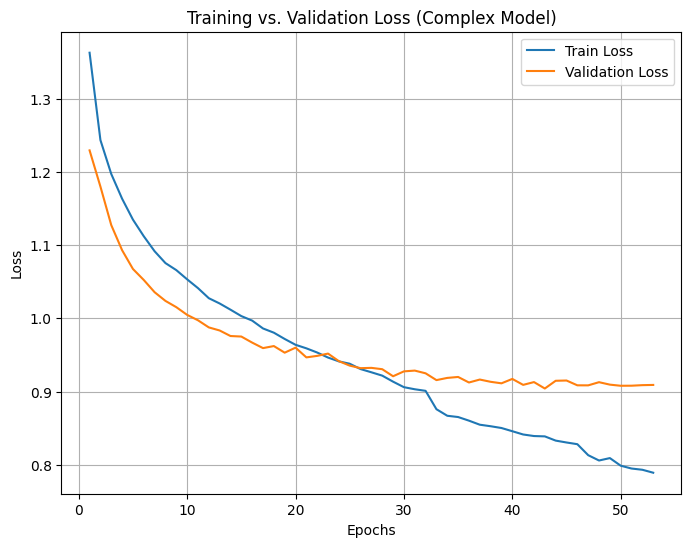

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (Complex Model)")
plt.legend()
plt.grid()
plt.show()


<ipython-input-22-c72909ee1dd8>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model1.pt'))  # Load the best model saved during trai

Test Accuracy: 0.6577

Classification Report:
              precision    recall  f1-score   support

     sadness       0.66      0.76      0.71      1227
         joy       0.73      0.80      0.76      1406
        love       0.47      0.26      0.33       341
       anger       0.63      0.51      0.56       569
        fear       0.54      0.53      0.53       472
    surprise       0.54      0.38      0.44       154

    accuracy                           0.66      4169
   macro avg       0.60      0.54      0.56      4169
weighted avg       0.65      0.66      0.65      4169



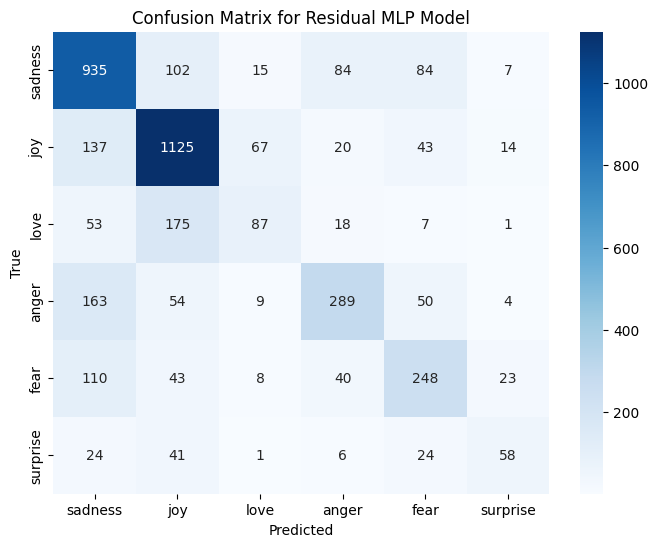

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model (if saved during early stopping)

model = ResidualMLP(input_dim, num_classes).to(device)  # Define the model again for evaluation
model.load_state_dict(torch.load('best_model1.pt'))  # Load the best model saved during training


# Switch model to evaluation mode
model.eval()

# Evaluate on test data
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)  # Use the consistent model instance
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_labels.cpu().numpy())


# Calculate Accuracy
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Define class names based on the label mapping in your dataset
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Classification Report
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names))  # Define class_names earlier

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Residual MLP Model")
plt.show()
